# Step 1: Experiment in a notebook
In this step you run data processing and model training and evaluation in the notebook locally. You don't use `sagemaker` or `boto3` packages.

![](img/six-steps-1.png)

<div class="alert alert-info"> Make sure you using <code>Data Science 3.0</code> image in Studio for this notebook.</div>

In [2]:
# We use the opensource xgboost algorithm to implement the model
%pip install -q xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np 
import json
import joblib
import xgboost as xgb
import sagemaker
import boto3
import os
import matplotlib.pyplot as plt
from time import gmtime, strftime, sleep
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


'2.210.0'

In [22]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
bucket_name                         -> 'sagemaker-us-east-1-598716374401'
bucket_prefix                       -> 'from-idea-to-prod/xgboost'
dataset_file_local_path             -> 'data/bank-additional/bank-additional-full.csv'
domain_id                           -> 'd-taruao9by6dl'
initialized                         -> True
input_s3_url                        -> 's3://sagemaker-us-east-1-598716374401/from-idea-t
region                              -> 'us-east-1'
sm_role                             -> 'arn:aws:iam::598716374401:role/service-role/Amazo
target_col                          -> 'y'


In [5]:
target_col = "y"

In [6]:
%store target_col

Stored 'target_col' (str)


In [23]:
session = sagemaker.Session()
sm = session.sagemaker_client

## Load data
The following cell is tagged with `parameters` as the cell tag to enable parametrization for headless execution of the notebook as [SageMaker Notebook-based workflow](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-auto-run.html). Refer to the section **Run the notebook as a SageMaker job** for details and an example. Ignore this for now.

In [9]:
# This cell is tagged with `parameters` tag and will be overwritten if the notebook executed headlessly
file_source = "EFS"
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
output_path = "./data"

In [12]:
# If run the notebook as a job, non-interactivel or headlessly, the notebook cannot access the Studio EFS volume, download the dataset from S3 instead
# See the section "Run the notebook as a SageMaker job" for more details
if file_source != "EFS":
    session.download_data(
        path=os.path.join(input_path, ""), 
        bucket=bucket_name,
        key_prefix=f"{bucket_prefix}/input/{file_name}"
    )

## EDA
Let's do some explotary data analysis on this dataset.

In [13]:
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

pd.set_option("display.max_columns", 500)  # View all of the columns
df_data  # show first 5 and last 5 rows of the dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [14]:
# see column metadata
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [15]:
# see column statistics
df_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


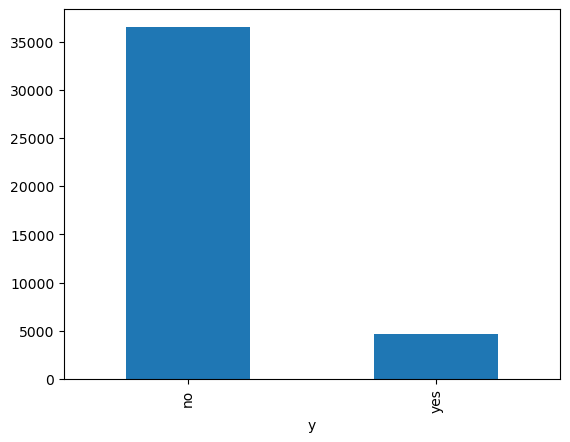

In [16]:
# see target distribution
df_data[target_col].value_counts().plot.bar()

plt.show()

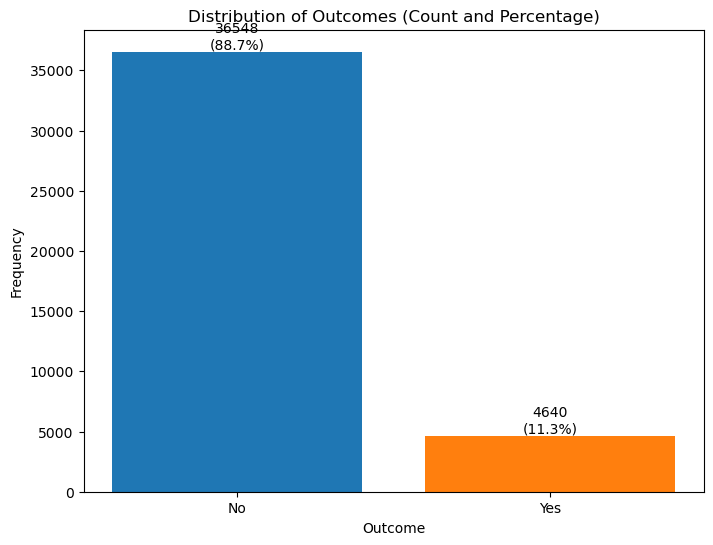

In [18]:
# Calculate value counts
value_counts = df_data[target_col].value_counts().sort_index()

# Calculate percentages
total = len(df_data[target_col])
percentages = (value_counts / total * 100).sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6)) # Customize figure size
bars = plt.bar(value_counts.index, value_counts.values, color=['#1f77b4', '#ff7f0e'])

# Add count and percentage labels on top of each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height,
             '{}\n({:.1f}%)'.format(height, percentage), ha='center', va='bottom')

# Add labels and title for clarity
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Distribution of Outcomes (Count and Percentage)')
plt.xticks([0, 1], ['No', 'Yes']) # Assuming binary outcomes are represented as 'no', 'yes'

# Show the plot
plt.show()

In [19]:
# see if there are any missing values
df_data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

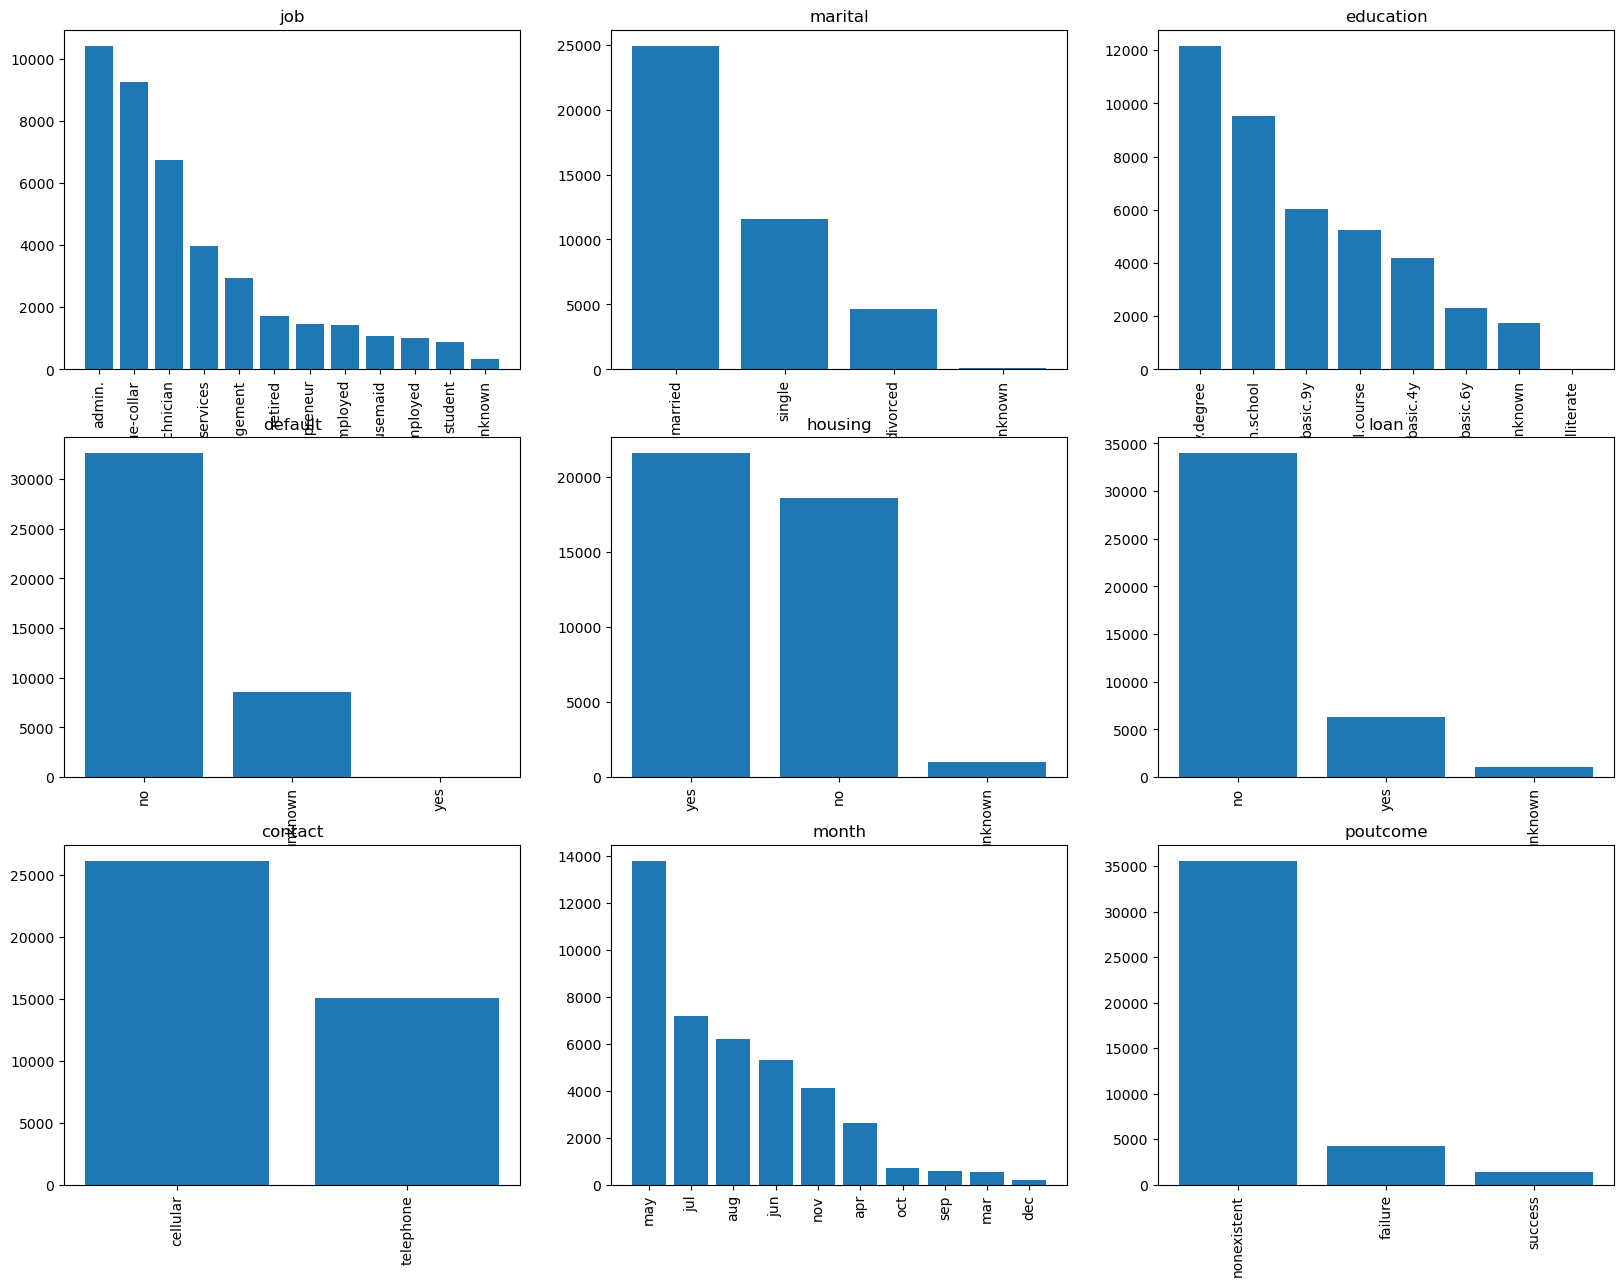

In [20]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df_data[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

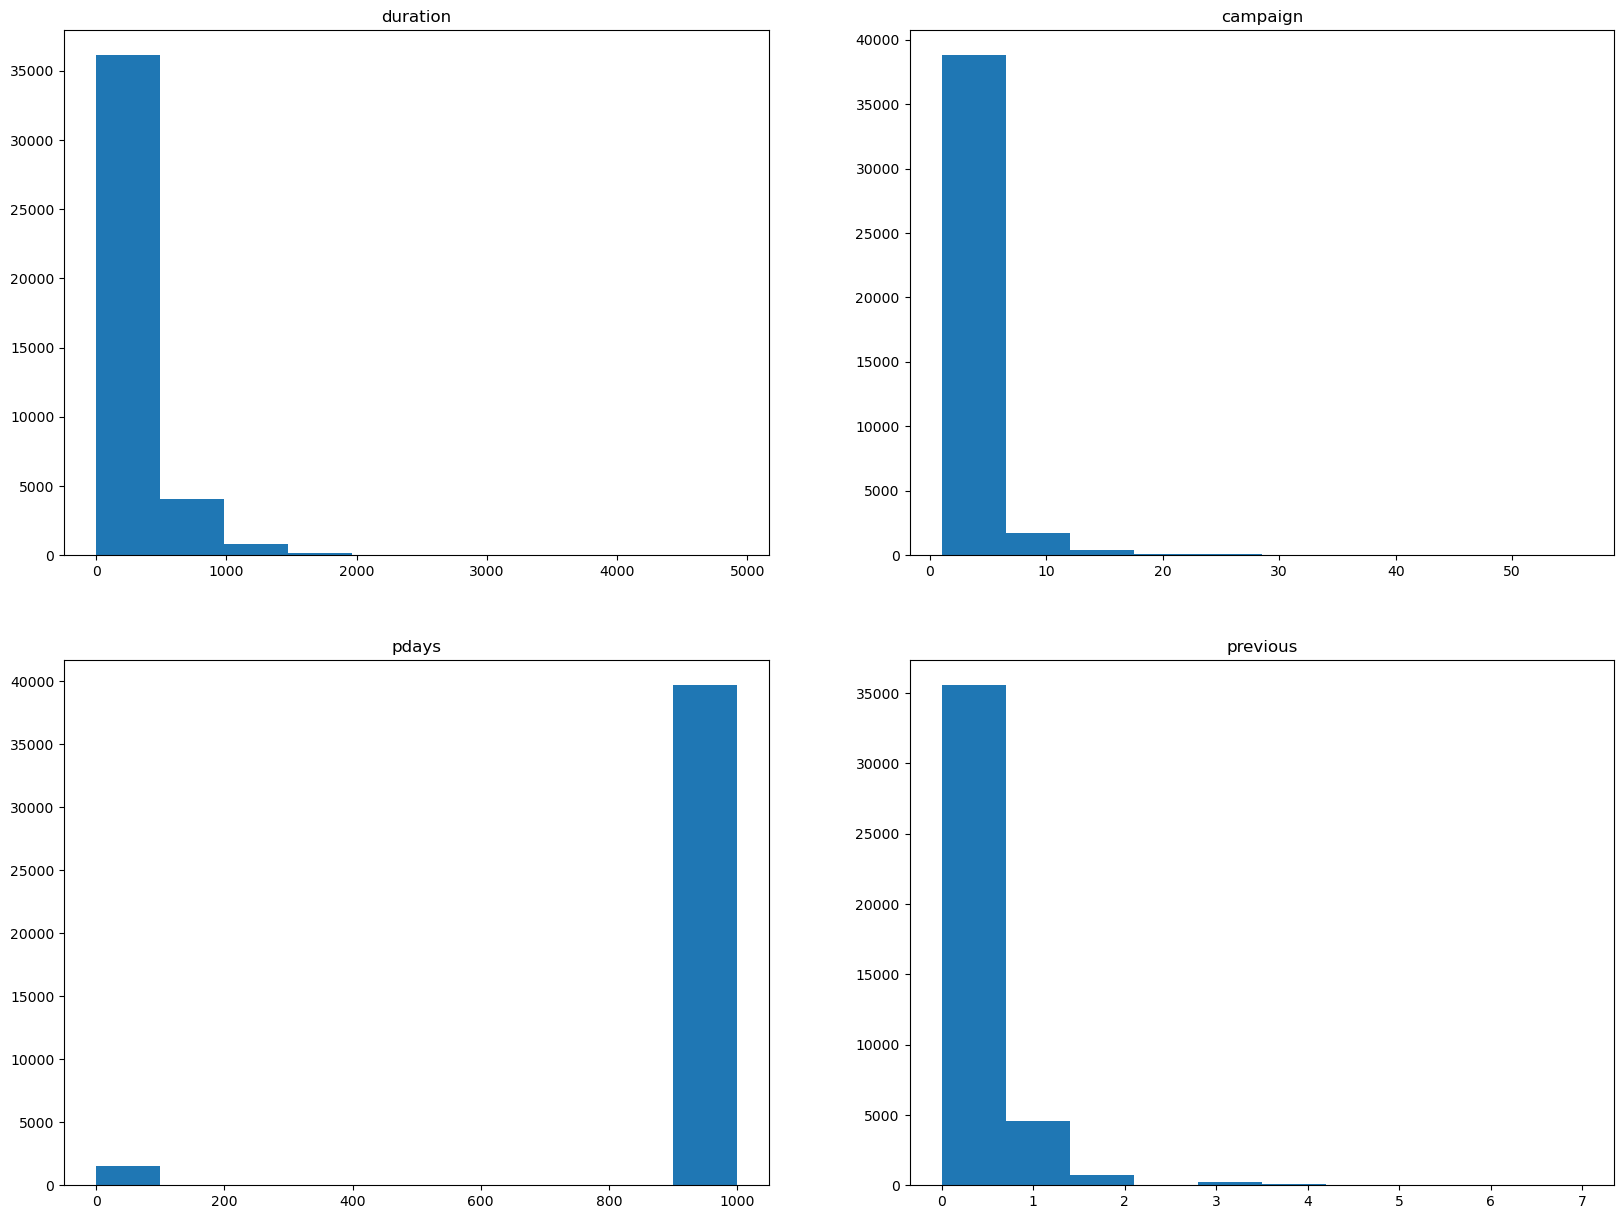

In [27]:
num_columns = ['duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 2
    trace_y = counter % 2
    
    axs[trace_x, trace_y].hist(df_data[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

<AxesSubplot:title={'center':'Marital status and deposit'}, xlabel='marital'>

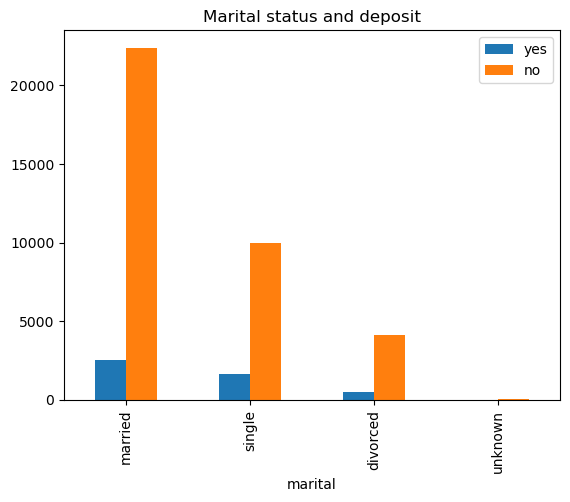

In [28]:
j_df = pd.DataFrame()

j_df['yes'] = df_data[df_data[target_col] == 'yes']['marital'].value_counts()
j_df['no'] = df_data[df_data[target_col] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

In [32]:
import seaborn as sns
from scipy.stats import mannwhitneyu

In [35]:
def mannwhitneyu_test(var):
    # Assuming df_data is your DataFrame, 'y' is the binary outcome variable, and 'X' is a numerical variable

    # Splitting the data into two groups based on 'y'
    group0 = df_data[df_data['y'] == 'no'][var]
    group1 = df_data[df_data['y'] == 'yes'][var]

    # Conducting the Mann-Whitney U Test
    stat, p_value = mannwhitneyu(group0, group1)

    print(f'Statistics: {stat}, P-value: {p_value}')

    # Interpretation of the result
    alpha = 0.05  # Threshold for significance
    if p_value < alpha:
        print('There is a statistically significant difference between the groups.')
    else:
        print('There is no statistically significant difference between the groups.')

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


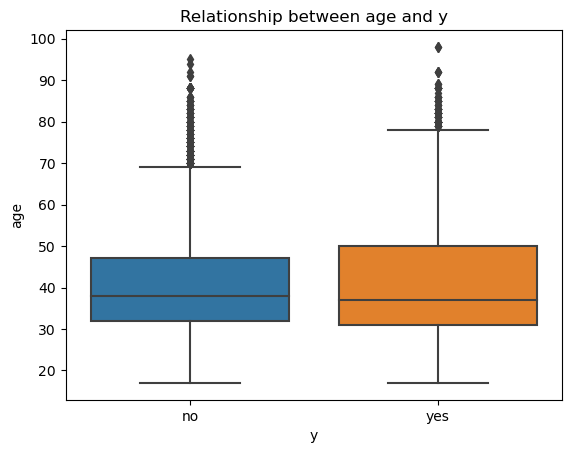

Statistics: 86626886.5, P-value: 0.01608053832750354
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


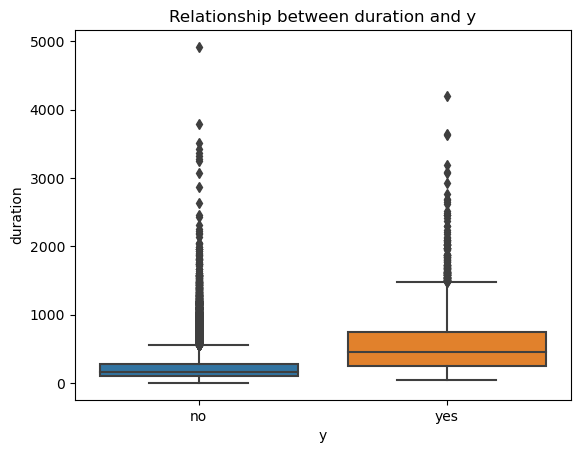

Statistics: 30788443.5, P-value: 0.0
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


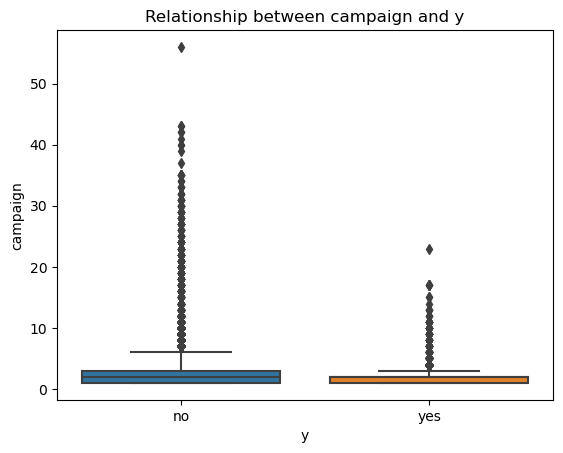

Statistics: 94153911.5, P-value: 3.4185266318612675e-38
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


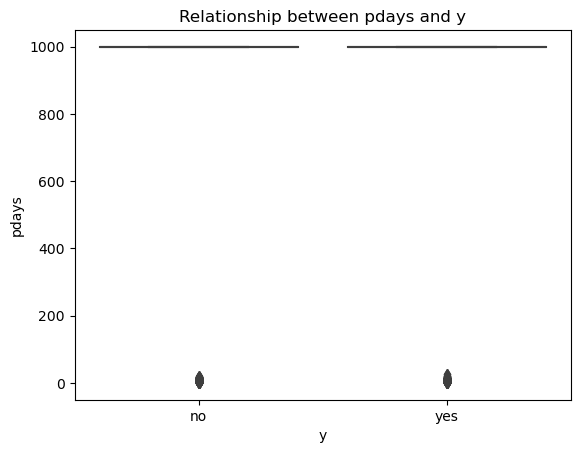

Statistics: 101197910.0, P-value: 0.0
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


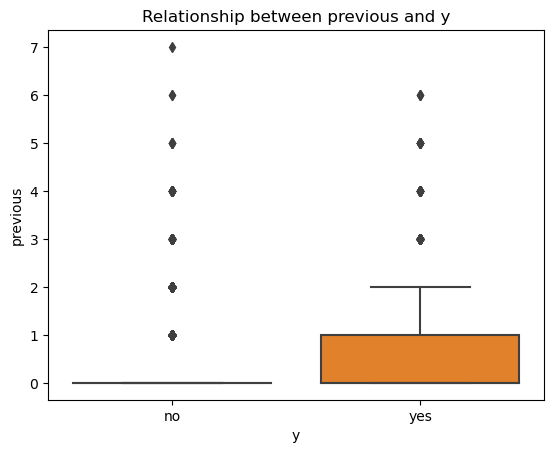

Statistics: 66257901.5, P-value: 0.0
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


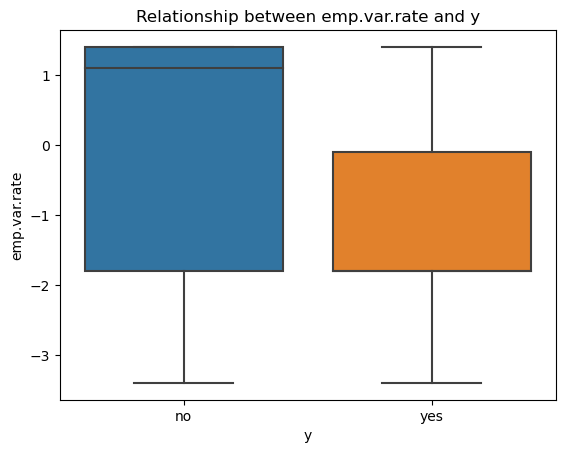

Statistics: 121548923.0, P-value: 0.0
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


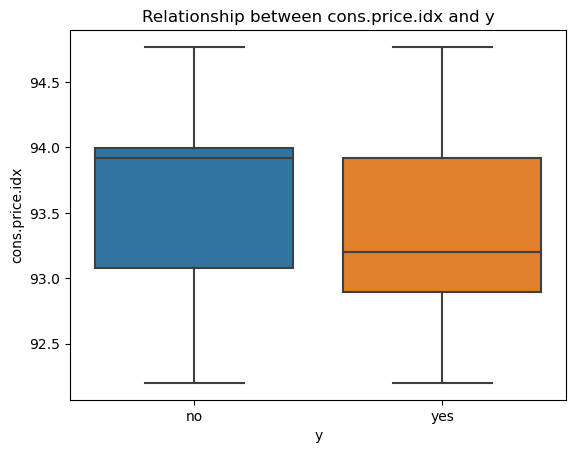

Statistics: 103540748.5, P-value: 9.572608866919173e-136
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


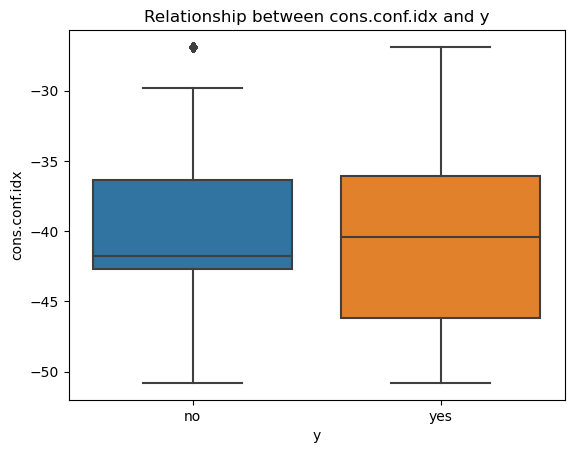

Statistics: 78464908.5, P-value: 5.901951166896614e-17
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


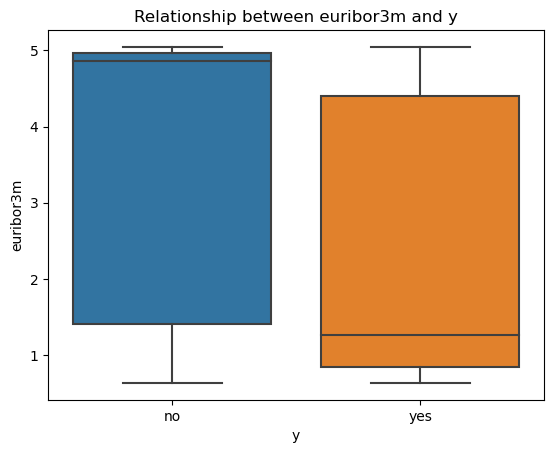

Statistics: 126080978.5, P-value: 0.0
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


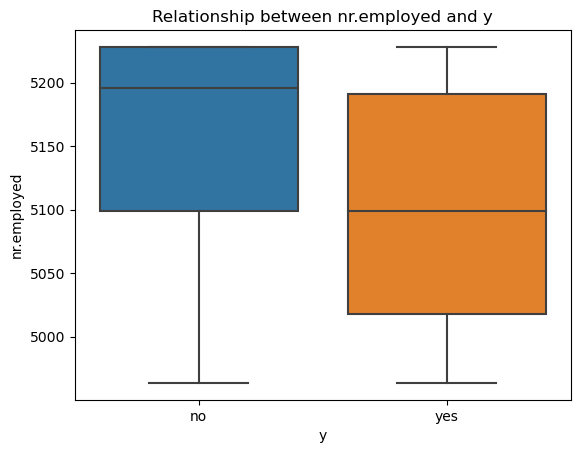

Statistics: 127016916.0, P-value: 0.0
There is a statistically significant difference between the groups.


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


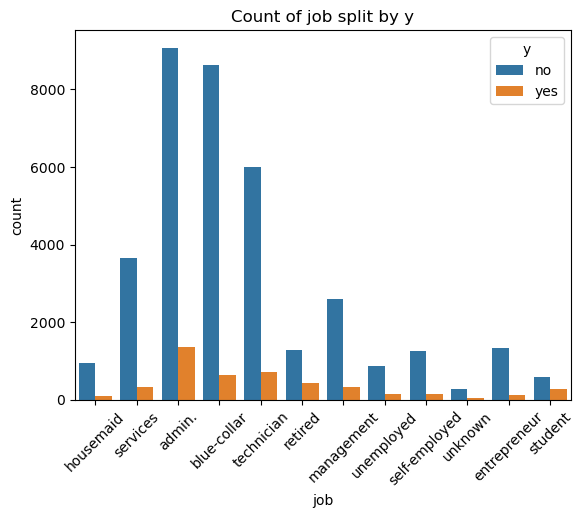

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


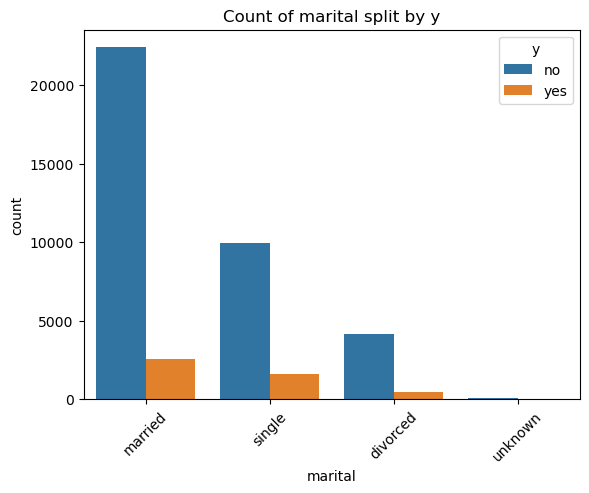

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


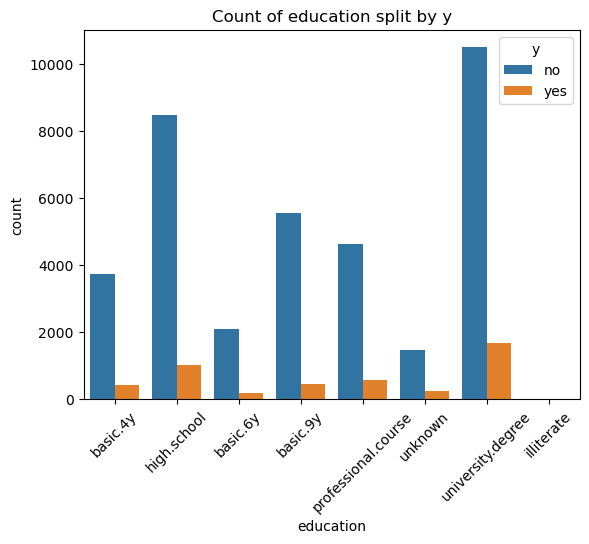

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


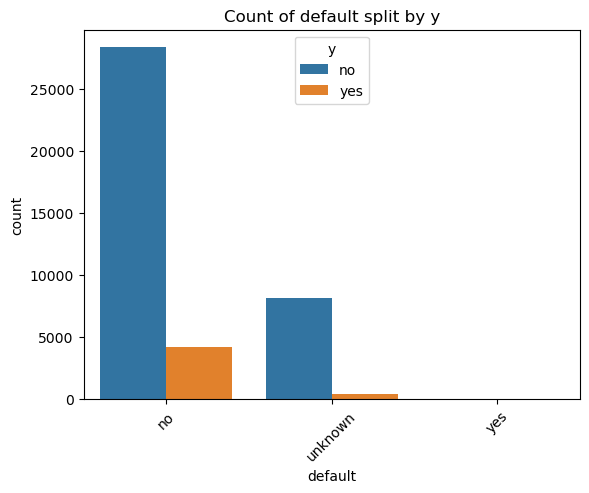

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


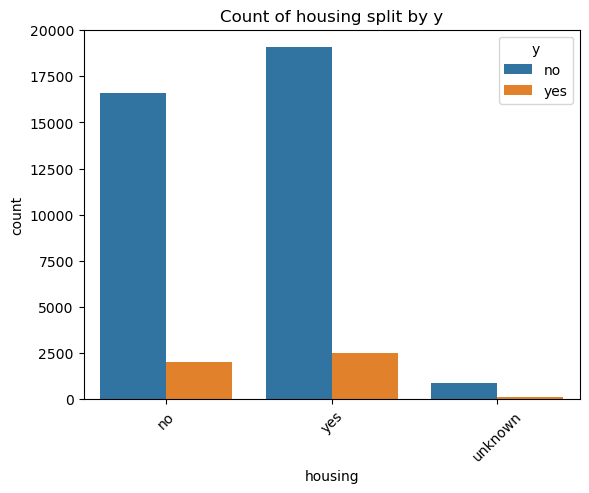

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


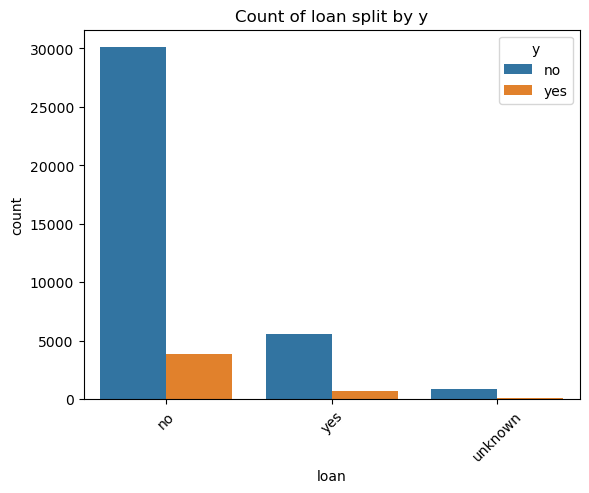

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


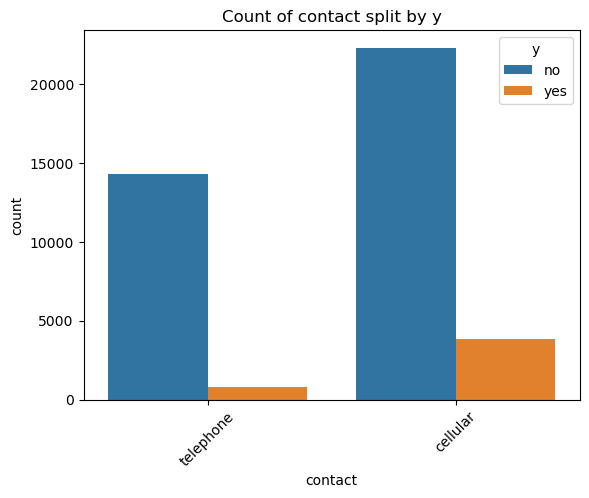

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


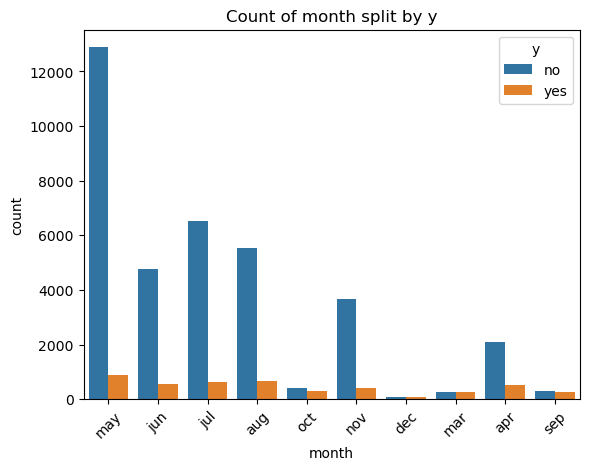

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


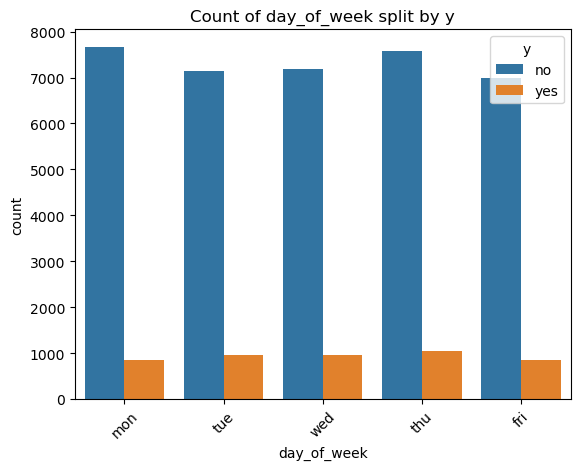

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


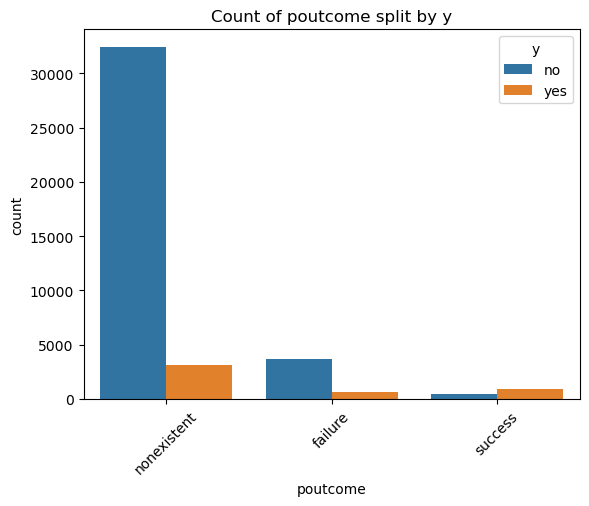

In [36]:
# For numerical variables
numerical_vars = df_data.select_dtypes(include=['int64', 'float64']).columns.drop('y', errors='ignore')
for var in numerical_vars:
    sns.boxplot(x='y', y=var, data=df_data)
    plt.title(f'Relationship between {var} and y')
    plt.show()
    mannwhitneyu_test(var)

# For categorical variables
categorical_vars = df_data.select_dtypes(include=['object', 'category']).columns.drop('y', errors='ignore')
for var in categorical_vars:
    sns.countplot(x=var, hue='y', data=df_data)
    plt.title(f'Count of {var} split by y')
    plt.xticks(rotation=45)  # Rotate labels for better readability if needed
    plt.show()

In [44]:
X1=X*1

In [45]:
print(X1.dtypes)

age                                int64
duration                           int64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
job_blue-collar                    int64
job_entrepreneur                   int64
job_housemaid                      int64
job_management                     int64
job_retired                        int64
job_self-employed                  int64
job_services                       int64
job_student                        int64
job_technician                     int64
job_unemployed                     int64
job_unknown                        int64
marital_married                    int64
marital_single                     int64
marital_unknown                    int64
education_basic.

In [47]:
import statsmodels.api as sm

# Assuming df_data is your DataFrame
# 'y' is the binary outcome variable with values 'yes' and 'no'
# The DataFrame contains both numeric and categorical predictors

# Step 1: Convert 'y' from 'yes'/'no' to 1/0 for logistic regression
df_data['y_numeric'] = df_data['y'].map({'yes': 1, 'no': 0})

# Step 2: Identify categorical variables (excluding the outcome variable)
# This might need to be adjusted based on the actual data
categorical_vars = df_data.select_dtypes(include=['object', 'category']).columns.drop(['y'])

# Step 3: One-hot encode the categorical variables
# Note: Setting drop_first=True to avoid multicollinearity by dropping one category
df_encoded = pd.get_dummies(df_data, columns=categorical_vars, drop_first=True)

# Step 4: Prepare the data for logistic regression
# Drop the original 'y' and any other non-predictor columns as necessary
X = df_encoded.drop(columns=['y', 'y_numeric'])
X1 = X*1
y = df_encoded['y_numeric']

# Adding a constant to the model for the intercept
X_const = sm.add_constant(X1)

# Step 5: Fit the logistic regression model
model = sm.Logit(y, X_const).fit()

# Step 6: Print the summary of the regression model to check the results
print(model.summary())

         Current function value: 0.207316
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              y_numeric   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41135
Method:                           MLE   Df Model:                           52
Date:                Wed, 06 Mar 2024   Pseudo R-squ.:                  0.4111
Time:                        18:00:33   Log-Likelihood:                -8538.9
converged:                      False   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -236.5999     38.307     -6.176      0.000    -311.681    -161.519
age     

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Warning
* Maximum number of iterations exceeded: This warning indicates that the model did not converge to a solution within the default number of iterations (35 in this case). This could suggest a complex model, potentially with multicollinearity or variables that don't significantly contribute to the model. Consider simplifying the model or increasing the maximum number of iterations.
### Model Fit Summary
* Dep. Variable: The dependent variable, y_numeric, which you're trying to predict.
* No. Observations: The total number of observations (data points) used, 41,188 in this case.
* Model: The model used, which is logistic regression (Logit).
* Method: The method of estimation, Maximum Likelihood Estimation (MLE).
* Df Residuals: Degrees of freedom of the residuals; calculated as No. Observations - Df Model - 1 (due to the intercept).
* Df Model: The number of predictors used in the model, 52 here.
* Pseudo R-squ.: A measure of model fit. The closer to 1, the better the model fits the data. Your model has a value of 0.4111, which indicates a reasonable fit.
* Log-Likelihood: The log of the likelihood function, with a value of -8538.9. This is used in the calculation of the model's AIC and BIC.
* LL-Null: The log-likelihood of a model with no predictors (only an intercept). This is -14499, indicating your model is an improvement over the null model.
* LLR p-value: The p-value associated with the test that all coefficients (except the intercept) are zero. A value of 0.000 suggests that your model as a whole is statistically significant.
### Coefficients Table
* The table lists each predictor, its coefficient (effect size), the standard error of the coefficient, the z-score (coefficient divided by its standard error), the p-value for the hypothesis test that the coefficient is zero, and the 95% confidence interval for the coefficient.

* Significant predictors: Variables like duration, campaign, pdays, emp.var.rate, cons.price.idx, etc., have small p-values, indicating they significantly predict the outcome.
* Insignificant predictors: Variables such as age, job_housemaid, marital_married, etc., have large p-values, suggesting they might not be significant predictors of the outcome.
* Coefficients interpretation: Positive coefficients increase the log odds of the outcome being 1 (assuming all other variables are held constant), while negative coefficients decrease it. For example, duration has a positive effect, increasing the likelihood of y_numeric being 1, while campaign has a negative effect.
### Model Diagnostics and Potential Issues
* Convergence Issue: Since the model didn't converge, results might not be reliable. Increasing the maximum number of iterations and checking for data issues or overly complex models may help.
* Coefficient for default_yes: The extremely large standard error for default_yes suggests instability in estimating this effect, potentially due to very few observations with default_yes = True or multicollinearity.
* nan values in std err for housing_unknown and loan_unknown: Indicates a problem with estimating these effects, possibly due to perfect prediction or collinearity.
### Next Steps
* Model Simplification: Consider removing variables that are not significant or variables causing instability in the model.
* Address Convergence: Increase the maximum number of iterations, check for multicollinearity, or simplify the model.
* Cross-validation: Perform cross-validation to assess the model's predictive performance on unseen data.

## Create an experiment
You can use [Amazon SageMaker Experiments Python SDK](https://sagemaker.readthedocs.io/en/stable/experiments/index.html) to organize all your model development work and track all model runs as `experiment runs`.

[SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) automatically track the inputs, parameters, configurations, and results of your iterations as `runs`.

Experiments are organized in `runs` and runs organized in `run groups`:

- `Experiment`: A collection of runs that are grouped together. An experiment includes runs for multiple types that can be initiated from anywhere using the SageMaker Python SDK.
- `Run`: Each execution step of a model training process. A run consists of all the inputs, parameters, configurations, and results for one iteration of model training. Custom parameters and metrics can be logged using the `log_parameter`, `log_parameters`, and `log_metric` functions. Custom input and output can be logged using the `log_file` function.

In [48]:
experiment_name = f"from-idea-to-prod-experiment-{strftime('%d-%H-%M-%S', gmtime())}"

In [50]:
print(experiment_name)

from-idea-to-prod-experiment-06-18-08-59


In [49]:
%store experiment_name

Stored 'experiment_name' (str)


## Feature engineering

As an example, the processing script implements the following feature engineering:
1. Create a new column called `no_previous_contact`. Set value to `1` when `pdays` is `999` and `0` otherwise
1. Generate a new column to show whether the customer is working based on `job` column
1. Remove the economic features from the dataset as they would need to be forecasted with high precision to be used as features during inference time
1. Remove `duration` as it is not know before a call is performed
1. Convert categorical variables to numeric using **one hot encoding**
1. Move the target column `y` to the front

In real world you implement additional processing, data quality handling, and feature engineering. You also go via multiple "try & fail" iterations.

In [71]:
# Indicator variable to capture when pdays takes a value of 999
df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

# Indicator for individuals not actively employed
df_data["not_working"] = np.where(
    np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
)

# remove unnecessary data
df_model_data = df_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)

df_model_data = df_model_data.drop(["y_numeric"], axis=1)

df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

# Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
df_model_data = pd.concat(
    [
        df_model_data["y_yes"].rename(target_col),
        df_model_data.drop(["y_no", "y_yes"], axis=1),
    ],
    axis=1,
)

In [72]:
df_model_data

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,False,56,1,999,0,1,0,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
1,False,57,1,999,0,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
2,False,37,1,999,0,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
3,False,40,1,999,0,1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
4,False,56,1,999,0,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,True,73,1,999,0,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False
41184,False,46,1,999,0,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False
41185,False,56,2,999,0,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False
41186,True,44,1,999,0,1,0,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False

## Split data

[SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) expects data in the libSVM or CSV formats, with:

- The target variable in the first column, and
- No header row

In [73]:
print(df_model_data.shape)

(41188, 60)


In [74]:
# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(
    df_model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
)

print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

Data split > train:(28831, 60) | validation:(8238, 60) | test:(4119, 60)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [75]:
# Save data to Studio filesystem
train_data.to_csv(os.path.join(output_path, "train.csv"), index=False, header=False)
validation_data.to_csv(os.path.join(output_path, "validation.csv"), index=False, header=False)
test_data.to_csv(os.path.join(output_path, "test.csv"), index=False, header=False)

## Model training and validation

In [76]:
train_features = train_data.drop(target_col, axis=1)
train_label = pd.DataFrame(train_data[target_col])

In [77]:
dtrain = xgb.DMatrix(train_features, label=train_label)

In [78]:
hyperparams = {
                "max_depth": 5,
                "eta": 0.5,
                "alpha": 2.5,
                "objective": "binary:logistic",
                "subsample" : 0.8,
                "colsample_bytree" : 0.8,
                "min_child_weight" : 3
              }

num_boost_round = 150
nfold = 3
early_stopping_rounds = 10

First, train the model on `nfold` number of folds of the training dataset and run a cross-validation.

In [79]:
# Cross-validate on training data
cv_results = xgb.cv(
    params=hyperparams,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    nfold=nfold,
    early_stopping_rounds=early_stopping_rounds,
    metrics=["auc"],
    seed=10,
)

In [80]:
metrics_data = {
    "binary_classification_metrics": {
        "validation:auc": {
            "value": cv_results.iloc[-1]["test-auc-mean"],
            "standard_deviation": cv_results.iloc[-1]["test-auc-std"]
        },
        "train:auc": {
            "value": cv_results.iloc[-1]["train-auc-mean"],
            "standard_deviation": cv_results.iloc[-1]["train-auc-std"]
        },
    }
}

In [81]:
print(f"Cross-validated train-auc:{cv_results.iloc[-1]['train-auc-mean']:.2f}")
print(f"Cross-validated validation-auc:{cv_results.iloc[-1]['test-auc-mean']:.2f}")

Cross-validated train-auc:0.79
Cross-validated validation-auc:0.77


In [82]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.713664,0.000906,0.712007,0.003146
1,0.744093,0.006690,0.738398,0.004829
2,0.764910,0.004827,0.759123,0.010130
3,0.774208,0.008026,0.764567,0.005680
4,0.780659,0.007469,0.766731,0.006558
5,0.782474,0.007728,0.766949,0.008145
6,0.785686,0.007571,0.768520,0.009155
7,0.788829,0.007052,0.769376,0.007299


Now retrain the model on the full training dataset instead of splitting the training dataset across a number of folds. Use the test dataset for early stopping.

In [83]:
test_features = test_data.drop(target_col, axis=1)
test_label = pd.DataFrame(test_data[target_col])
dtest = xgb.DMatrix(test_features, label=test_label)

### Create a run
Create a new run using the [`Run`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#run) class and call the [`log_parameters()`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#sagemaker.experiments.Run.log_parameters) and [`log_artifact()`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#sagemaker.experiments.Run.log_artifact) methods to record information to the run.

You can use [`log_file()`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#sagemaker.experiments.Run.log_file) method to upload local files to S3 to persistently store all data for the run.

In [84]:
run_suffix = strftime('%Y-%m-%M-%S', gmtime())

with Run(experiment_name=experiment_name,
         run_name=f"feature-engineering-{run_suffix}",
         run_display_name="feature-engineering",
         sagemaker_session=session) as run:
    run.log_parameters(
        {
            "train": 0.7,
            "validate": 0.2,
            "test": 0.1
        }
    )
    # Log input dataset metadata and output
    run.log_artifact(name="marketing-dataset", value="./data/bank-additional/bank-additional-full.csv", media_type="text/csv", is_output=False)
    run.log_artifact(name="train-csv", value="./data/train.csv", media_type="text/csv")
    run.log_artifact(name="validation-csv", value="./data/validation.csv", media_type="text/csv")
    run.log_artifact(name="test-csv", value="./data/test.csv", media_type="text/csv")

### Train a model
Use the class[`Run`](https://sagemaker.readthedocs.io/en/stable/experiments/sagemaker.experiments.html#run) to log model metrics.

In [85]:
# in the production code you need to use the unique ids
run_suffix = strftime('%Y-%m-%M-%S', gmtime())

# Train the model for different max_depth values
for i, d in enumerate([2, 5, 10, 15, 20]):
    hyperparams["max_depth"] = d
    
    print(f"Fit estimator with max_depth={d}")
    run_name = f"training-{i}-{run_suffix}"
    
    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name=f"max-depth-{d}",
             sagemaker_session=session) as run:
        # Train the model
        model = (
            xgb.train(
                params=hyperparams, 
                dtrain=dtrain, 
                evals = [(dtrain,'train'), (dtest,'eval')], 
                num_boost_round=num_boost_round, 
                early_stopping_rounds=early_stopping_rounds, 
                verbose_eval = 0
            )
        )

        # Calculate metrics
        test_auc = roc_auc_score(test_label, model.predict(dtest))
        train_auc = roc_auc_score(train_label, model.predict(dtrain))
        
        # Log metrics to the run
        run.log_parameters(hyperparams)
        run.log_metric(name="test_auc", value = test_auc, step=d)
        run.log_metric(name="train_auc", value = train_auc, step=d)

        # time.sleep(8) # wait until resource tags are propagated to the run

        print(f"Test AUC: {test_auc:.4f} | Train AUC: {train_auc:.4f}")

Fit estimator with max_depth=2
Test AUC: 0.7714 | Train AUC: 0.7848
Fit estimator with max_depth=5
Test AUC: 0.7627 | Train AUC: 0.8066
Fit estimator with max_depth=10
Test AUC: 0.7581 | Train AUC: 0.8590
Fit estimator with max_depth=15
Test AUC: 0.7516 | Train AUC: 0.8740
Fit estimator with max_depth=20
Test AUC: 0.7543 | Train AUC: 0.8835


## Explore experiment runs with Studio UX
You can see all logged metrics, parameters, and artifacts in Studio UX in **SageMaker Home** > **Experiments** widget.

For example, select your experiment:

![](img/experiment-and-runs.png)

In the experiment list, select the experiment to display a list of the runs in the experiment:

![](img/runs.png)

You can select runs you would like to analyse and click **Analyze**. A new window with selected runs opens:

![](img/run-analyze.png)

Now you can analyse the runs, compare the data, and create charts:

![](img/experiments-run-analysis.png)

Refer to [Next generation Amazon SageMaker Experiments – Organize, track, and compare your machine learning trainings at scale](https://aws.amazon.com/blogs/machine-learning/next-generation-amazon-sagemaker-experiments-organize-track-and-compare-your-machine-learning-trainings-at-scale/) blog post for more examples and details on SageMaker Experiments.

## Use experiment analytics
You can use the [analytics features](https://sagemaker.readthedocs.io/en/stable/api/training/analytics.html#analytics) of the Experiment SDK to query and compare the runs and identify the best model produced by your experiments.

Refer to these [notebooks](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-experiments) for hands-on examples.

## Optional: Run the notebook as a SageMaker job
Sometimes there are scenarious in which you might want to run your notebooks as a non-interactive, scheduled jobs. Studio provides fast and simple tools built from the existing Amazon EventBridge, SageMaker Training and SageMaker Pipelines services to help you schedule your notebook jobs interactively. You don’t have to craft your own custom solution or enlist features from other services that may require additional overhead in time and costs to deploy.

You can run your notebook as a SageMaker job on-demand on based on any schedule you choose. You can also run multiple notebooks in parallel, and parametrize cells in your notebooks.

### Adapt the notebook to run headlessly
A headless notebook runs in a shell outside of the Studio environment. Therefore, your code in the notebook cannot depend on or access the Studio local storage, environment variables, or Python store. You must accordingly change any code which uses the local Studio environment.

### How to run
Follow the instructions in [Notebook-based Workflows](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-auto-run.html) in the Developer Guide to run this notebook in non-interactive mode as a SageMaker job:
1. [Configure](https://docs.aws.amazon.com/sagemaker/latest/dg/scheduled-notebook-policies.html) the trust policy and additional IAM permissions for the Studio execution role. If you run this notebook in the domain in the AWS-preprovisioned account, the required permissions are automatically deployed
2. Provide the parameters as specified below
3. Run the notebook on-demand or schedule a job
4. Explore the results

### Set parameters

In [86]:
# output the name of the S3 bucket used by SageMaker – you need this value as bucket_name parameter
print(bucket_name)

sagemaker-us-east-1-598716374401


In [87]:
# If running interactively, upload data to S3 to have it here for a headless run
if file_source == 'EFS':
    input_s3_url = session.upload_data(
        path=os.path.join(input_path, file_name),
        bucket=bucket_name,
        key_prefix=f"{bucket_prefix}/input"
    )
    
    print(input_s3_url)

s3://sagemaker-us-east-1-598716374401/from-idea-to-prod/xgboost/input/bank-additional-full.csv


To parameterize your notebook, you [set](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-auto-run-troubleshoot-override.html) a tag `parameters` on a single cell in your notebook that marks it as the "parameter cell". SageMaker notebook execution will insert a new generated cell directly after that cell tagged with `parameters` at runtime. The generated cell will have code which sets the parameters with values you specifiy when you start an execution job.

The notebook execution job has no access to the Studio EFS volume. Any data you need to pass to the notebook must be copied to an S3 bucket, where the notebook can access it.

To run this notebook as a SageMaker job, choose the **Create a notebook job** icon in the notebook taskbar: 

![](img/notebook-as-sm-job-run.png)

Complete the popup form.

![](img/notebook-as-sm-job-parameters.png)

Set the following parameters to specified values in **Parameter** section of the form:

```
file_source = S3
input_path = /opt/ml/input/data/sagemaker_headless_execution 
output_path = /opt/ml/output/data
bucket_name = SET TO YOUR SAGEMAKER BUCKET NAME
bucket_prefix = from-idea-to-prod/xgboost
```

Select **Run now** or **Run on a schedule** and choose **Create**.

You can also [create a notebook job programmatically with SageMaker Python SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/create-notebook-auto-run-sdk.html). 

---

## Continue with the step 2
open the step 2 [notebook](02-sagemaker-containers.ipynb).

## Further development ideas for your real-world projects
- Try different models, for example some of the [SageMaker built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html), such as [CatBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost.html), [AutoGluon-Tabular](https://docs.aws.amazon.com/sagemaker/latest/dg/autogluon-tabular.html), or [Linear Learner Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html)
- Try [SageMaker Autopilot](https://aws.amazon.com/sagemaker/autopilot/) to automatically explore different solutions to find the best model. Refer to this hands-on tutorial: [Automatically Create Machine Learning Models](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-automatically-create-models/)
- Implement batch inference using [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html)

## Additional resources
- [Build and Train a Machine Learning Model Locally](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-build-model-locally/)
- [Amazon SageMaker XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)
- [Automatically Create Machine Learning Models](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-automatically-create-models/)
- [Operationalize your Amazon SageMaker Studio notebooks as scheduled notebook jobs](https://aws.amazon.com/blogs/machine-learning/operationalize-your-amazon-sagemaker-studio-notebooks-as-scheduled-notebook-jobs/)
- [Dataset transformations](https://scikit-learn.org/stable/data_transforms.html)
- [Extracting, transforming and selecting features](https://spark.apache.org/docs/latest/ml-features.html)

# Shutdown kernel

In [88]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>